In [18]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim

In [19]:
# Define the categories (labels)
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "EB1"},
    {"id": 2, "name": "EB2"},
    {"id": 3, "name": "EB3"},
    {"id": 4, "name": "FW"},
    {"id": 5, "name": "HUNT"},
    {"id": 6, "name": "OVAL"},
    {"id": 8, "name": "security-station"},
    {"id": 9, "name": "sign"},
    {"id": 10, "name": "street-lamp"},
    {"id": 12, "name": "trashcan"},
]

# Load the model
model_save_path = "model_epoch_1.pth"

In [24]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = 11
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# Load the model 
model_save_path = "model_epoch_1.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([14, 1024]) from checkpoint, the shape in current model is torch.Size([11, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([11]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([56, 1024]) from checkpoint, the shape in current model is torch.Size([44, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([44]).

In [8]:
# Define the image transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load and preprocess the images
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0)

# Function to visualize predictions
def visualize_predictions(images, predictions, threshold=0.5):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 6))

    for ax, image, prediction in zip(axs, images, predictions):
        # Convert the tensor image to a NumPy array and transpose the dimensions
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score >= threshold:
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'{label_to_category.get(label, "Unknown")}: {score:.2f}', 
                        bbox=dict(facecolor='yellow', alpha=0.5))

        ax.axis('off')

    plt.show()

In [9]:
# Annotate images in COCO format
def annotate_images_in_folder(folder_path, output_json_path, threshold=0.5):
    image_id = 1
    annotation_id = 1
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = load_image(image_path).to(device)

            with torch.no_grad():
                prediction = model(image)

            image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
            height, width, _ = image_np.shape

            coco_annotations["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": width,
                "height": height
            })

            boxes = prediction[0]['boxes'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()
            labels = prediction[0]['labels'].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                if score >= threshold:
                    xmin, ymin, xmax, ymax = box
                    width = xmax - xmin
                    height = ymax - ymin
                    coco_annotations["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [xmin, ymin, width, height],
                        "score": float(score)
                    })
                    annotation_id += 1

            image_id += 1

    with open(output_json_path, 'w') as f:
        json.dump(coco_annotations, f, indent=4)

In [14]:
# Specify the folder containing test images and the output JSON path
test_images_folder = 'images/test_img'
output_json_path = 'annotations.json'

# Annotate images and save annotations in COCO format
annotate_images_in_folder(test_images_folder, output_json_path)

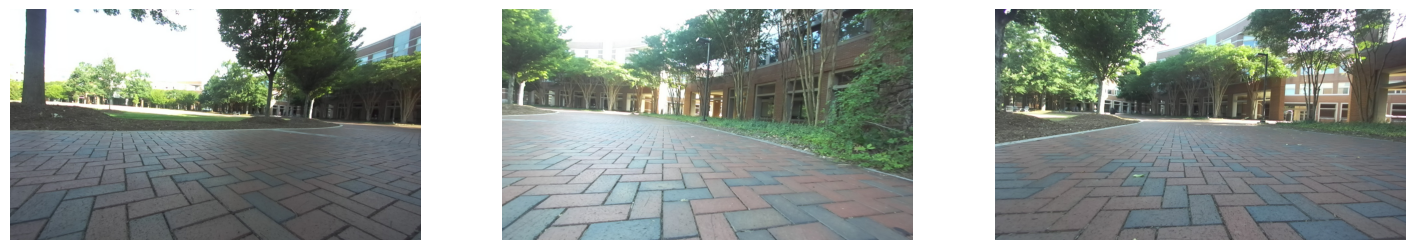

In [15]:
# Optional: Visualize some predictions
test_image_paths = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder)[:3]]
test_images = [load_image(p).to(device) for p in test_image_paths]
with torch.no_grad():
    predictions = [model(img) for img in test_images]

visualize_predictions(test_images, predictions)